In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# TensorBoard Graph visualizer in notebook
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [53]:
def load_mnist_data():

    # Read input_data (not as one_hot)
    from tensorflow.examples.tutorials.mnist import input_data

    # new folder
    mnist = input_data.read_data_sets("/tmp/data/")

    # Assign them to values
    x_train = mnist.train.images
    x_test = mnist.test.images
    y_train = mnist.train.labels.astype("int")
    y_test = mnist.test.labels.astype("int")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [58]:
def initialize_graph():
    tf.reset_default_graph()

    n_inputs = 28*28  
    n_hidden1 = 300
    n_hidden2 = 200
    n_hidden3 = 100
    n_outputs = 10

    # Placeholders for data (inputs and targets)
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.int64, shape=(None), name="y")

    # Define neuron layers (ReLU in hidden layers)
    # We'll take care of Softmax for output with loss function

    def neuron_layer(X, n_neurons, name, activation=None):
        # X input to neuron
        # number of neurons for the layer
        # name of layer
        # pass in eventual activation function

        with tf.name_scope(name):
            n_inputs = int(X.get_shape()[1])

            # initialize weights to prevent vanishing / exploding gradients
            stddev = 2 / np.sqrt(n_inputs)
            init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)

            # Initialize weights for the layer
            W = tf.Variable(init, name="weights")
            # biases
            b = tf.Variable(tf.zeros([n_neurons]), name="bias")

            # Output from every neuron
            Z = tf.matmul(X, W) + b
            if activation is not None:
                return activation(Z)
            else:
                return Z

    # Define the hidden layers
    keep_prob = 1.0
    with tf.name_scope("dnn"):
        hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                               activation=tf.nn.tanh)
        drop_out1 = tf.nn.dropout(hidden1, keep_prob)

        hidden2 = neuron_layer(drop_out1, n_hidden2, name="hidden2",
                               activation=tf.nn.tanh)
        drop_out2 = tf.nn.dropout(hidden2, keep_prob)

        hidden3 = neuron_layer(drop_out2, n_hidden3, name="hidden3",
                               activation=tf.nn.tanh)
        drop_out3 = tf.nn.dropout(hidden3, keep_prob)

        logits = neuron_layer(drop_out3, n_outputs, name="outputs")

In [61]:
def define_scopes():

    # Define loss function (that also optimizes Softmax for output):

    with tf.name_scope("loss"):
        # logits are from the last output of the dnn
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

    # Training step with Gradient Descent

    learning_rate = 0.001

    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

    # Evaluation to see accuracy

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [62]:
show_graph(tf.get_default_graph())

In [63]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 10
batch_size = 50

epoch_arr = []
acc_tr_arr = []
acc_v_arr = []

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         for i in range(len(x_train)//batch_size):
#             batch_xs, batch_ys = next_batch(batch_size, x_train, y_train)
#         #     print(batch_xs)
#             sess.run(training_op, feed_dict={X: batch_xs, y: batch_ys})

#         acc_train = accuracy.eval(feed_dict={X: batch_xs, y: batch_ys})
#         acc_val = accuracy.eval(feed_dict={X: x_test,
#                                             y: y_test})
        
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
        epoch_arr.append(epoch)
        acc_tr_arr.append(acc_train)
        acc_v_arr.append(acc_val)

    save_path = saver.save(sess, "models/my_model_final.ckpt") # save model

0 Train accuracy: 0.9 Val accuracy: 0.8176
1 Train accuracy: 0.9 Val accuracy: 0.8688
2 Train accuracy: 0.9 Val accuracy: 0.8882
3 Train accuracy: 0.86 Val accuracy: 0.8978
4 Train accuracy: 0.92 Val accuracy: 0.9074
5 Train accuracy: 0.9 Val accuracy: 0.912
6 Train accuracy: 0.96 Val accuracy: 0.9154
7 Train accuracy: 0.92 Val accuracy: 0.919
8 Train accuracy: 0.96 Val accuracy: 0.9218
9 Train accuracy: 0.92 Val accuracy: 0.9242


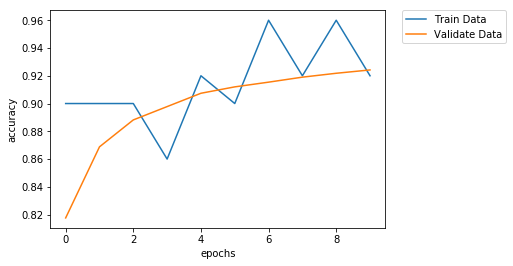

In [64]:
plt.plot(epoch_arr, acc_tr_arr, label="Train Data")
plt.plot(epoch_arr, acc_v_arr, label="Validate Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()